In [2]:
# 📦 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from scipy.stats import shapiro
from google.colab import files

# 📁 NanumBarunGothic.ttf 업로드
print("📌 NanumBarunGothic.ttf 파일을 업로드하세요")
uploaded_fonts = files.upload()
font_path = list(uploaded_fonts.keys())[0]

# 📌 폰트 설정
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['axes.unicode_minus'] = False

📌 NanumBarunGothic.ttf 파일을 업로드하세요


Saving NanumBarunGothic.ttf to NanumBarunGothic.ttf


    MODEL ABC_class XYZ_class Group
0    N002         A         X    AX
1    N003         A         X    AX
2    N001         A         Y    AY
3   MM001         A         Y    AY
4    P002         A         X    AX
5   MM002         A         Z    AZ
6   NB003         A         Y    AY
7    B003         A         X    AX
8   TN001         A         X    AX
9   EN002         B         Z    BZ
10  NB001         B         Y    BY
11  TN002         B         X    BX
12   B001         B         X    BX
13  TN003         B         Y    BY
14  NB002         B         Y    BY
15  ZI003         B         Y    BY
16  EN001         B         Z    BZ
17   P001         B         X    BX
18   B002         C         X    CX
19  LN002         C         Z    CZ
20  ZI001         C         Z    CZ
21   P003         C         X    CX
22  EN003         C         Y    CY
23  LN001         C         Y    CY
24  MM003         C         Z    CZ
25  LN003         C         Y    CY
26  PA001         C         

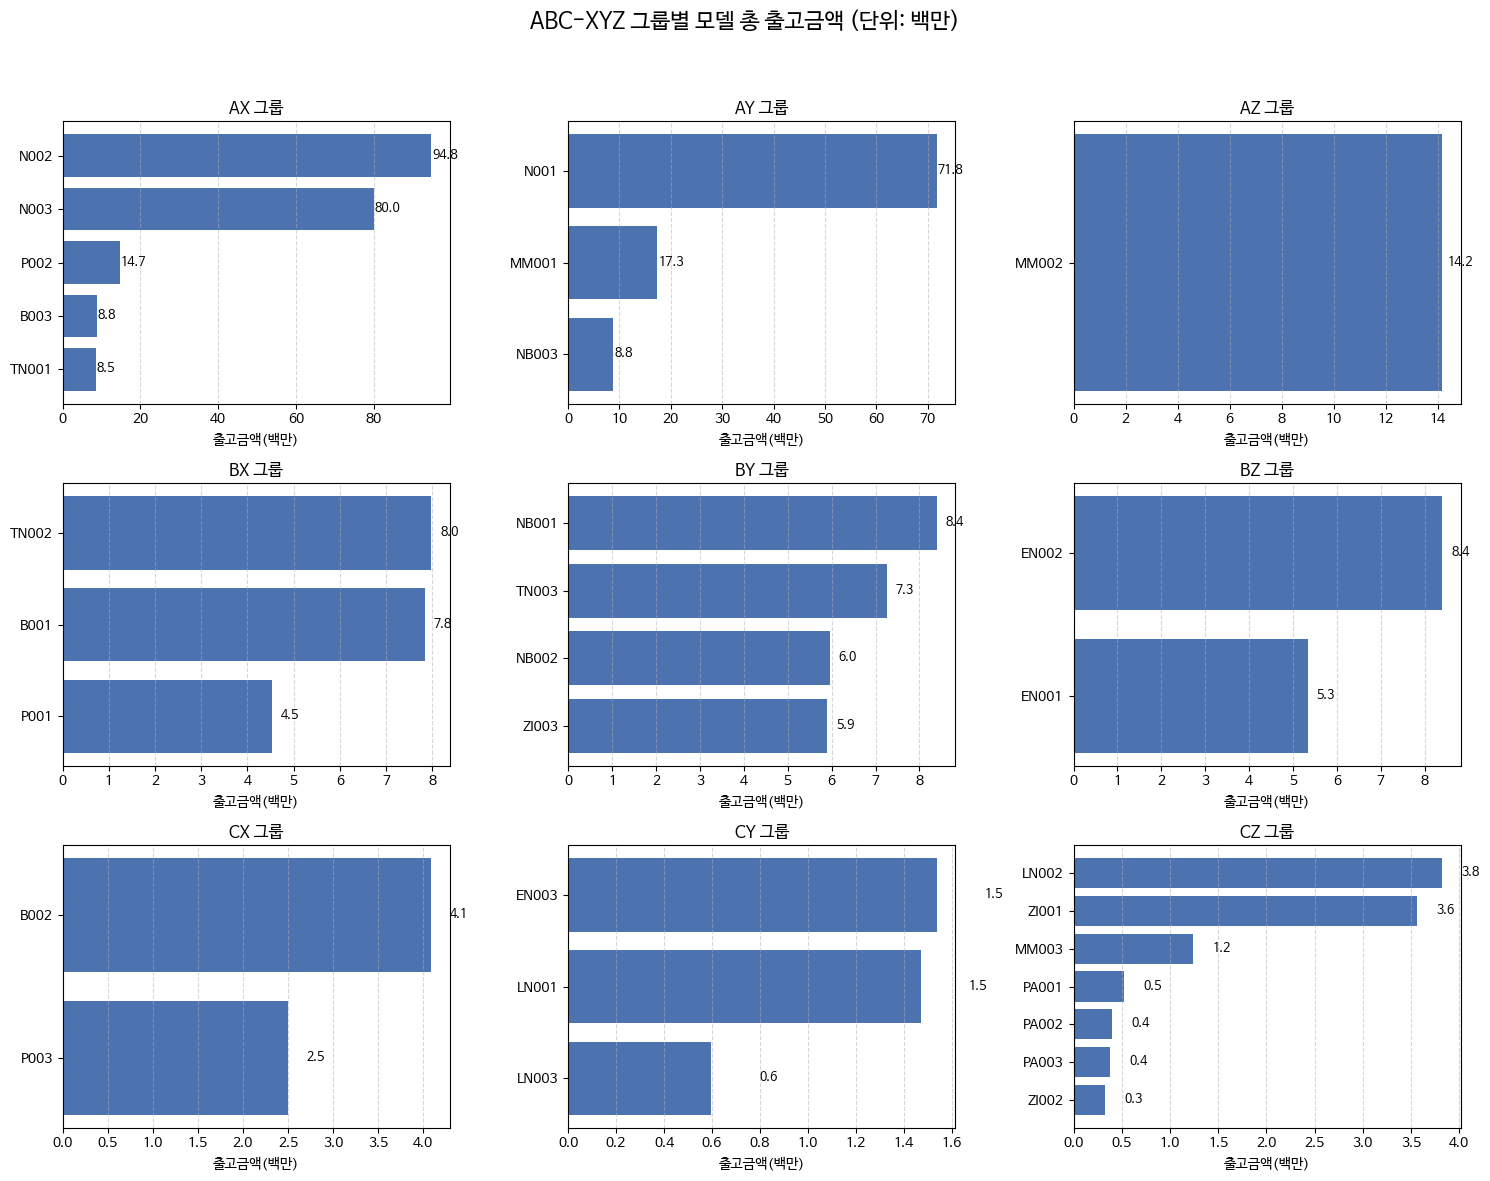

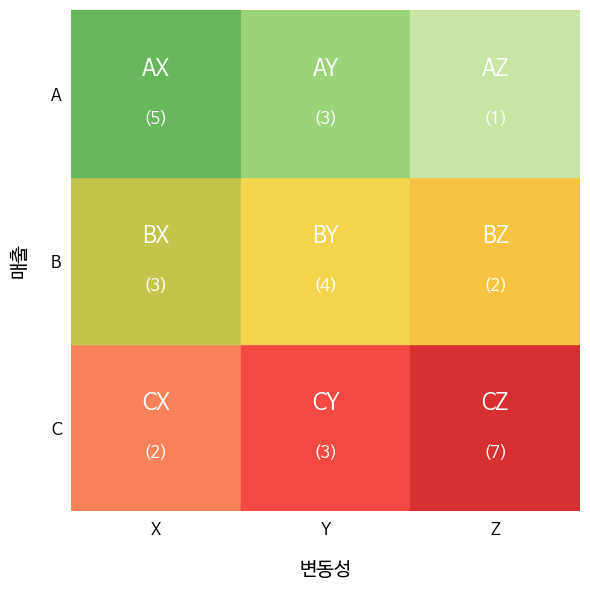

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# [1] 데이터 로드 및 ABC 분석
# -----------------------------
df = pd.read_excel("/content/sample_data/전체분포_3년출고.xlsx", sheet_name=0)

df_amt = df.groupby('MODEL')['GI_AMT'].sum().reset_index()
df_amt_sorted = df_amt.sort_values('GI_AMT', ascending=False)
total_amt = df_amt_sorted['GI_AMT'].sum()
df_amt_sorted['cumulative_pct'] = df_amt_sorted['GI_AMT'].cumsum() / total_amt * 100

def abc_grade(cum_pct):
    if cum_pct <= 80:
        return 'A'
    elif cum_pct <= 95:
        return 'B'
    else:
        return 'C'

df_amt_sorted['ABC_class'] = df_amt_sorted['cumulative_pct'].apply(abc_grade)

# -----------------------------
# [2] XYZ 분석 (변동계수 기준)
# -----------------------------
df_stats = df.groupby('MODEL')['GI'].agg(['mean', 'std']).reset_index()
df_stats['CV'] = df_stats['std'] / df_stats['mean']

df_stats_sorted = df_stats.sort_values('CV', ascending=True).reset_index(drop=True)
n = len(df_stats_sorted)
x_cut = n // 3
y_cut = 2 * (n // 3)

df_stats_sorted.loc[:x_cut-1, 'XYZ_class'] = 'X'
df_stats_sorted.loc[x_cut:y_cut-1, 'XYZ_class'] = 'Y'
df_stats_sorted.loc[y_cut:, 'XYZ_class'] = 'Z'

# -----------------------------
# [3] 결과 병합 및 저장
# -----------------------------
df_class = pd.merge(df_amt_sorted[['MODEL', 'ABC_class']],
                    df_stats_sorted[['MODEL', 'XYZ_class']], on='MODEL')
df_class['Group'] = df_class['ABC_class'] + df_class['XYZ_class']

# 저장 및 출력
df_class.to_csv("/content/sample_data/model_classification.csv", index=False)
print(df_class)

# -----------------------------
# [4] 그룹별 출고금액 바 차트 (서브플롯 통합 출력 & 하나의 이미지 저장)
# -----------------------------
groups_order = ['AX', 'AY', 'AZ', 'BX', 'BY', 'BZ', 'CX', 'CY', 'CZ']
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('ABC-XYZ 그룹별 모델 총 출고금액 (단위: 백만)', fontsize=16)

for idx, group in enumerate(groups_order):
    row, col = divmod(idx, 3)
    ax = axes[row, col]

    sub = df_class[df_class['Group'] == group]
    if not sub.empty:
        sub = pd.merge(sub, df_amt_sorted[['MODEL','GI_AMT']], on='MODEL')
        sub = sub.sort_values('GI_AMT', ascending=True)
        models = sub['MODEL'].tolist()
        values = (sub['GI_AMT'] / 1_000_000).tolist()

        bars = ax.barh(models, values, color='#4c72b0')
        for bar in bars:
            w = bar.get_width()
            ax.text(w + 0.2, bar.get_y() + bar.get_height()/2,
                    f"{w:.1f}", va='center', fontsize=9)
        ax.set_title(f"{group} 그룹", fontsize=12)
    else:
        ax.set_title(f"{group} 그룹 (모델 없음)", fontsize=12)

    ax.set_xlabel("출고금액(백만)")
    ax.set_xlim(left=0)
    ax.grid(axis='x', linestyle='--', alpha=0.5)

# 빈 축 비활성화
for ax in axes.flat:
    if not ax.has_data():
        ax.set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("/content/sample_data/group_bar_charts.png")
plt.show()

# -----------------------------
# [5] ABC-XYZ 매트릭스 직접 그리기
# -----------------------------
group_counts = df_class['Group'].value_counts().to_dict()

color_map = {
    'AX': '#68b75c', 'AY': '#9bd478', 'AZ': '#c7e6a4',
    'BX': '#c4c44d', 'BY': '#f4d44d', 'BZ': '#f9c342',
    'CX': '#f9825a', 'CY': '#f34943', 'CZ': '#d63031'
}

rows = ['A', 'B', 'C']
cols = ['X', 'Y', 'Z']

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

for i, row in enumerate(rows[::-1]):
    for j, col in enumerate(cols):
        group = row + col
        count = group_counts.get(group, 0)
        color = color_map.get(group, 'lightgray')
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        ax.text(j + 0.5, i + 0.65, group, ha='center', va='center', fontsize=16, weight='bold', color='white')
        ax.text(j + 0.5, i + 0.35, f'({count})', ha='center', va='center', fontsize=12, color='white')

ax.set_xticks([0.5, 1.5, 2.5])
ax.set_yticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['X', 'Y', 'Z'], fontsize=12)
ax.set_yticklabels(['C', 'B', 'A'], fontsize=12)

ax.set_xlabel("변동성", fontsize=14, labelpad=15)
ax.set_ylabel("매출", fontsize=14, labelpad=15)

ax.tick_params(left=False, bottom=False)
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("/content/sample_data/abc_xyz_matrix_generated.png")
plt.show()
